# Notebook 01 – Data Preprocessing

**Pipeline stages covered:**
1. Load raw datasets (CIC-DDoS2019 + CIC-IDS2018)
2. Exploratory visualization (class distribution, null values)
3. Remove duplicates, NaN / Inf values
4. One-hot encode labels
5. Visualize cleaned data
6. Persist cleaned dataset for Notebook 02

> **Data leakage note:** Scaling and encoding are intentionally deferred to
> Notebook 02, *after* the train/test split.

In [1]:
# ── Imports ────────────────────────────────────────────────────────────────
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from utils.data_loader   import load_all_datasets
from utils.preprocessing import (
    remove_duplicates_and_nulls,
    split_features_labels,
    fit_label_encoder,
    encode_labels,
    get_label_mapping,
)
from utils.visualization import (
    plot_label_distribution,
    plot_missing_values,
)

print('✓ Imports OK')

✓ Imports OK


In [ ]:
# ── Configuration ──────────────────────────────────────────────────────────
DDOS2019_DIR  = '../data/CIC-DDoS2019'
ids2018_dir   = '../data/CIC-IDS2018'
OUTPUT_DIR    = '../data/processed'
LABEL_COL     = 'Label'

# Set SAMPLE_FRAC < 1.0 for quick development runs; use None for full data
SAMPLE_FRAC   = None   # e.g. 0.05 for 5 % of each file
RANDOM_STATE  = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f'Output directory: {os.path.abspath(OUTPUT_DIR)}')

Output directory: e:\Documents\Programming\Python\project\AI\Transformer DDoS Detector\data\processed


## 1 · Load Datasets

In [ ]:
df_raw = load_all_datasets(
    ddos2019_dir=DDOS2019_DIR,
    ids2018_dir=ids2018_dir,
    sample_frac=SAMPLE_FRAC,
    random_state=RANDOM_STATE,
)
print(f'\nRaw dataset shape: {df_raw.shape}')
df_raw.head(3)

Loading CIC-DDoS2019: 100%|██████████| 11/11 [00:27<00:00,  2.53s/it]


[data_loader] Dropping metadata columns: ['src_ip', 'dst_ip', 'timestamp']
[data_loader] Loaded 11 file(s) from 'CIC-DDoS2019' → 2,177,197 rows × 73 cols
[data_loader] Class distribution:
Label
DrDoS_LDAP       200000
DrDoS_MSSQL      200000
DrDoS_NTP        200000
DrDoS_NetBIOS    200000
DrDoS_SNMP       200000
DrDoS_SSDP       200000
DrDoS_UDP        200000
Syn              200000
TFTP             200000
UDP-lag          199745
Portmap          177197
WebDDoS             255



Loading CIC-IDS2018: 100%|██████████| 1/1 [00:03<00:00,  3.34s/it]


[data_loader] Dropping metadata columns: ['src_ip', 'dst_ip', 'timestamp']
[data_loader] Loaded 1 file(s) from 'CIC-IDS2018' → 200,000 rows × 73 cols
[data_loader] Class distribution:
Label
Benign    200000


[data_loader] Combined dataset: 2,377,197 rows × 73 cols
[data_loader] Overall class distribution:
Label
DrDoS_LDAP       200000
DrDoS_MSSQL      200000
DrDoS_NTP        200000
DrDoS_NetBIOS    200000
DrDoS_SNMP       200000
DrDoS_SSDP       200000
DrDoS_UDP        200000
Syn              200000
TFTP             200000
Benign           200000
UDP-lag          199745
Portmap          177197
WebDDoS             255


Raw dataset shape: (2377197, 73)


,src_port,dst_port,protocol,flow_duration,flow_byts_s,flow_pkts_s,fwd_pkts_s,bwd_pkts_s,tot_fwd_pkts,tot_bwd_pkts,...,idle_min,idle_mean,idle_std,fwd_byts_b_avg,fwd_pkts_b_avg,bwd_byts_b_avg,bwd_pkts_b_avg,fwd_blk_rate_avg,bwd_blk_rate_avg,Label
0,943,27116,17,2,1.472000e+09,1000000.0,1000000.0,0.0,2,0,...,0.0,0.0,0.0,0,0,0,0,0,0,DrDoS_LDAP
1,516,14878,17,1,2.848000e+09,2000000.0,2000000.0,0.0,2,0,...,0.0,0.0,0.0,0,0,0,0,0,0,DrDoS_LDAP
2,764,7822,17,1,2.944000e+09,2000000.0,2000000.0,0.0,2,0,...,0.0,0.0,0.0,0,0,0,0,0,0,DrDoS_LDAP


## 2 · Exploratory Analysis — Raw Data

In [4]:
# Data types and memory
print('=== Dataset Info ===')
print(f'Rows: {df_raw.shape[0]:,}  |  Columns: {df_raw.shape[1]}')
print(f'Memory usage: {df_raw.memory_usage(deep=True).sum() / 1e6:.1f} MB')
display(df_raw.dtypes.value_counts().rename('dtype count'))

=== Dataset Info ===
Rows: 2,377,197  |  Columns: 73
Memory usage: 1407.9 MB


float64    43
int64      29
str         1
Name: dtype count, dtype: int64

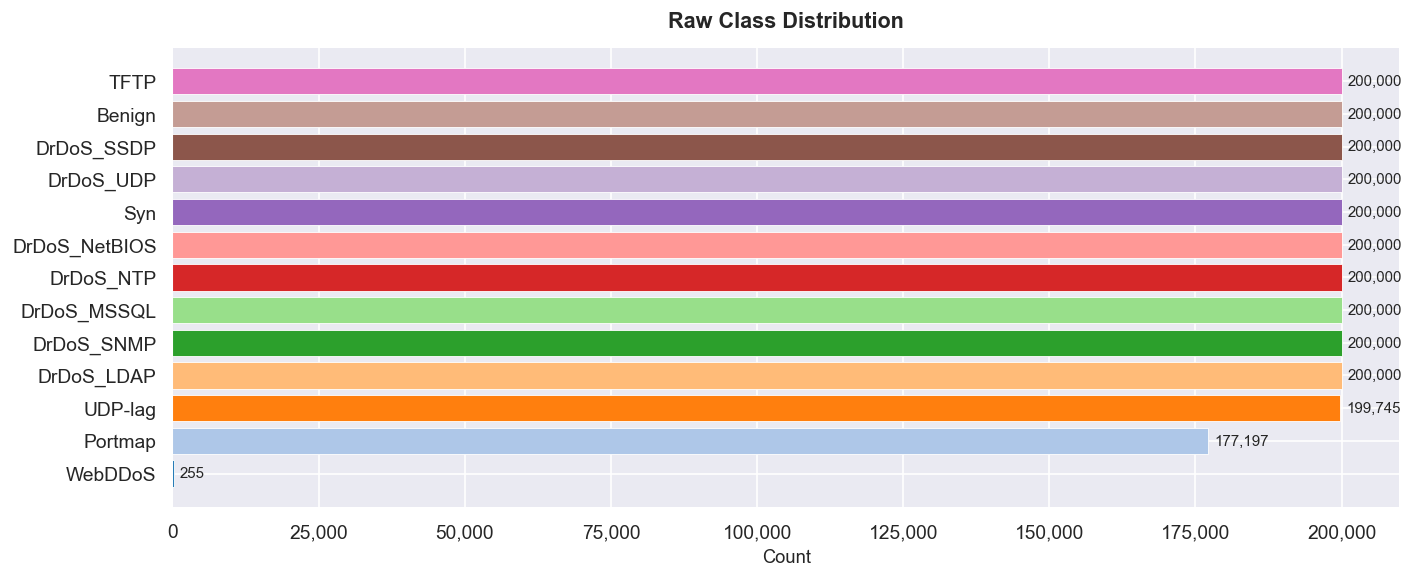

In [5]:
# ── Raw class distribution ─────────────────────────────────────────────────
fig = plot_label_distribution(df_raw[LABEL_COL], title='Raw Class Distribution')
fig.savefig(f'{OUTPUT_DIR}/fig_01_raw_class_dist.png', dpi=120, bbox_inches='tight')
plt.show()

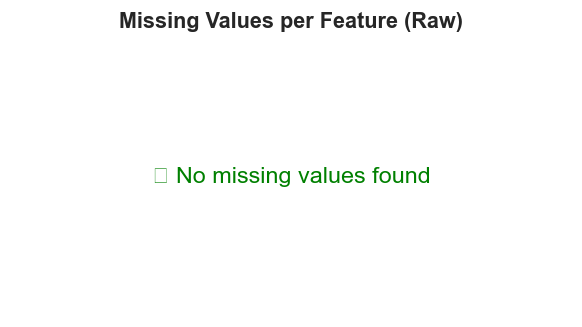

Total NaN: 0  |  Total Inf: 0  |  Duplicates: 1,789


In [6]:
# ── Missing / null values ──────────────────────────────────────────────────
fig = plot_missing_values(df_raw, title='Missing Values per Feature (Raw)')
fig.savefig(f'{OUTPUT_DIR}/fig_02_missing_values.png', dpi=120, bbox_inches='tight')
plt.show()

total_null = df_raw.isnull().sum().sum()
total_inf  = np.isinf(df_raw.select_dtypes('number')).sum().sum()
total_dup  = df_raw.duplicated().sum()
print(f'Total NaN: {total_null:,}  |  Total Inf: {total_inf:,}  |  Duplicates: {total_dup:,}')

## 3 · Cleaning — Remove Duplicates, NaN, and Inf

In [7]:
df_clean = remove_duplicates_and_nulls(df_raw, verbose=True)
print(f'\nCleaned dataset shape: {df_clean.shape}')

[preprocessing] Original rows :  2,377,197
[preprocessing] Removed duplicates :      1,789
[preprocessing] Removed NaN/Inf :          0
[preprocessing] Remaining rows :  2,375,408

Cleaned dataset shape: (2375408, 73)


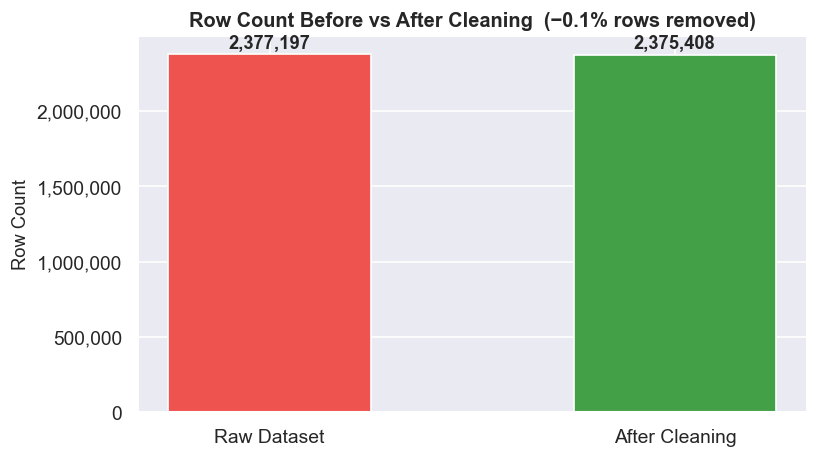

In [8]:
# ── Rows removed summary chart ─────────────────────────────────────────────
raw_count    = df_raw.shape[0]
clean_count  = df_clean.shape[0]
removed_pct  = (1 - clean_count / raw_count) * 100

fig, ax = plt.subplots(figsize=(7, 4), dpi=120)
bars = ax.bar(
    ['Raw Dataset', 'After Cleaning'],
    [raw_count, clean_count],
    color=['#EF5350', '#43A047'], width=0.5, edgecolor='white'
)
for bar, val in zip(bars, [raw_count, clean_count]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + raw_count*0.005,
            f'{val:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_ylabel('Row Count', fontsize=11)
ax.set_title(f'Row Count Before vs After Cleaning  (−{removed_pct:.1f}% rows removed)',
             fontsize=12, fontweight='bold')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
fig.savefig(f'{OUTPUT_DIR}/fig_03_cleaning_counts.png', dpi=120, bbox_inches='tight')
plt.show()

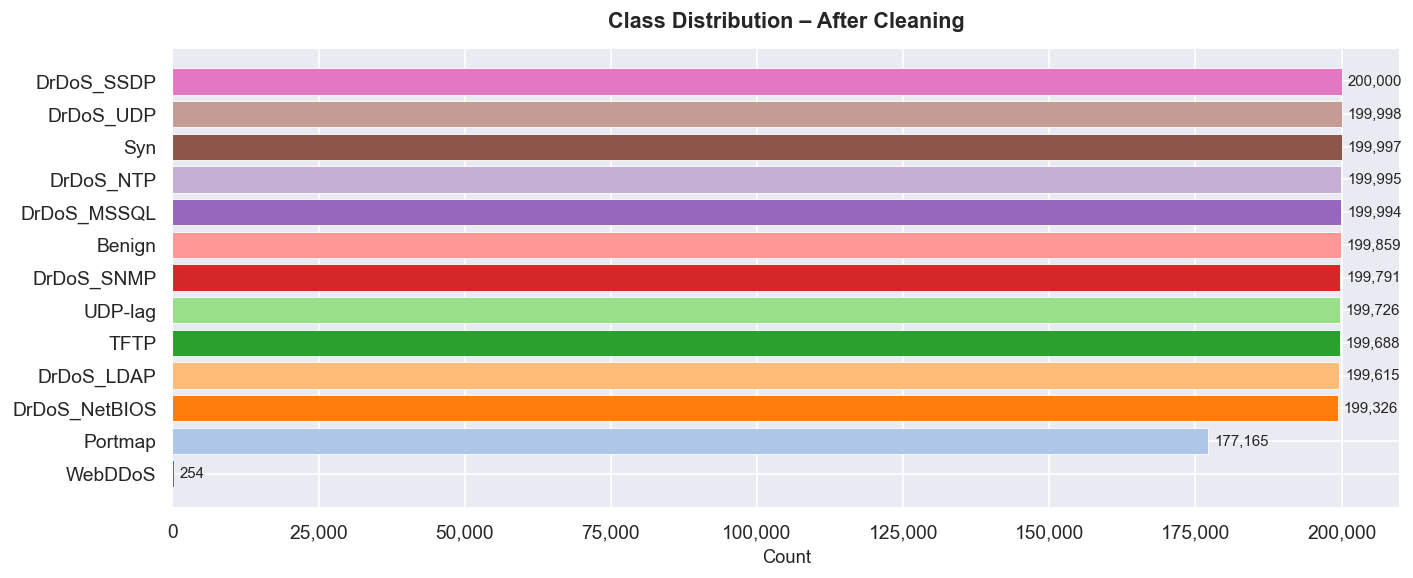

In [9]:
# ── Class distribution after cleaning ─────────────────────────────────────
fig = plot_label_distribution(df_clean[LABEL_COL], title='Class Distribution – After Cleaning')
fig.savefig(f'{OUTPUT_DIR}/fig_04_clean_class_dist.png', dpi=120, bbox_inches='tight')
plt.show()

## 4 · Label Encoding (One-Hot)

The `LabelBinarizer` is fitted here **only for display purposes**.
The authoritative fit happens in Notebook 02 on the training split.

In [10]:
X, y, feature_names = split_features_labels(df_clean, label_col=LABEL_COL)

# Fit a temporary encoder to show the mapping
temp_encoder = fit_label_encoder(y)
label_mapping = get_label_mapping(temp_encoder)

print('One-Hot Encoding Mapping (Label → Encoded Vector):')
print('-' * 55)
for cls, vec in label_mapping.items():
    print(f'  {cls:<30} → {vec}')
print(f'\nTotal classes: {len(label_mapping)}')

One-Hot Encoding Mapping (Label → Encoded Vector):
-------------------------------------------------------
  Benign                         → [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_LDAP                     → [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_MSSQL                    → [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_NTP                      → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_NetBIOS                  → [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_SNMP                     → [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_SSDP                     → [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
  DrDoS_UDP                      → [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  Portmap                        → [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
  Syn                            → [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
  TFTP                           → [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
  UDP-lag                        → [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

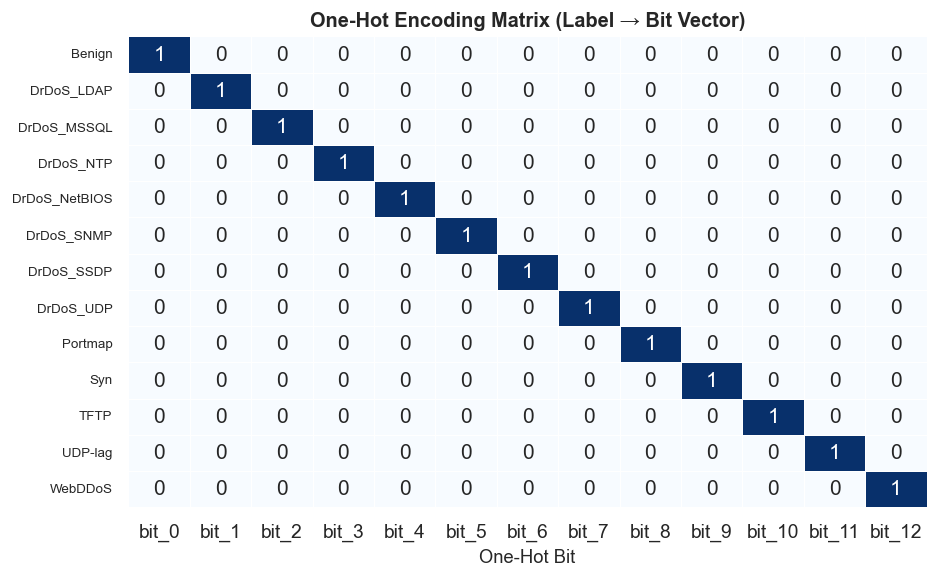

In [11]:
# Visualise the one-hot mapping as a table-style heatmap
import seaborn as sns

mapping_df = pd.DataFrame(
    {cls: vec for cls, vec in label_mapping.items()}
).T
mapping_df.columns = [f'bit_{i}' for i in range(mapping_df.shape[1])]

fig, ax = plt.subplots(figsize=(max(8, len(label_mapping)*0.5), 5), dpi=120)
sns.heatmap(
    mapping_df.astype(int),
    annot=True, fmt='d', cmap='Blues',
    linewidths=0.5, cbar=False, ax=ax
)
ax.set_xlabel('One-Hot Bit', fontsize=11)
ax.set_title('One-Hot Encoding Matrix (Label → Bit Vector)', fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
fig.savefig(f'{OUTPUT_DIR}/fig_05_onehot_matrix.png', dpi=120, bbox_inches='tight')
plt.show()

## 5 · Feature Summary

In [12]:
# Statistical summary of numeric features
desc = X.describe().T
display(desc.style.background_gradient(cmap='Blues', subset=['mean', 'std']))

,count,mean,std,min,25%,50%,75%,max
src_port,2375408.000000,26133.729023,25149.741450,0.000000,771.000000,22520.000000,51380.000000,65535.000000
dst_port,2375408.000000,30766.831693,20022.440863,0.000000,12870.000000,30709.000000,48466.000000,65535.000000
protocol,2375408.000000,14.627184,4.543362,0.000000,17.000000,17.000000,17.000000,17.000000
flow_duration,2375408.000000,2640073.541464,14019042.483445,1.000000,1.000000,2.000000,1725.000000,119999991.000000
flow_byts_s,2375408.000000,561047552.086761,819318979.654538,0.000000,1016.535101,62857142.857143,808000000.000000,2944000000.000000
flow_pkts_s,2375408.000000,1039070.158467,922484.958620,0.016675,6849.315068,1000000.000000,2000000.000000,4000000.000000
fwd_pkts_s,2375408.000000,1038331.265276,923121.440240,0.010579,4778.047347,1000000.000000,2000000.000000,4000000.000000
bwd_pkts_s,2375408.000000,738.893191,12126.312094,0.000000,0.000000,0.000000,0.000000,2000000.000000
tot_fwd_pkts,2375408.000000,8.397880,129.898068,1.000000,2.000000,2.000000,4.000000,91081.000000
tot_bwd_pkts,2375408.000000,0.680406,49.996047,0.000000,0.000000,0.000000,0.000000,21706.000000


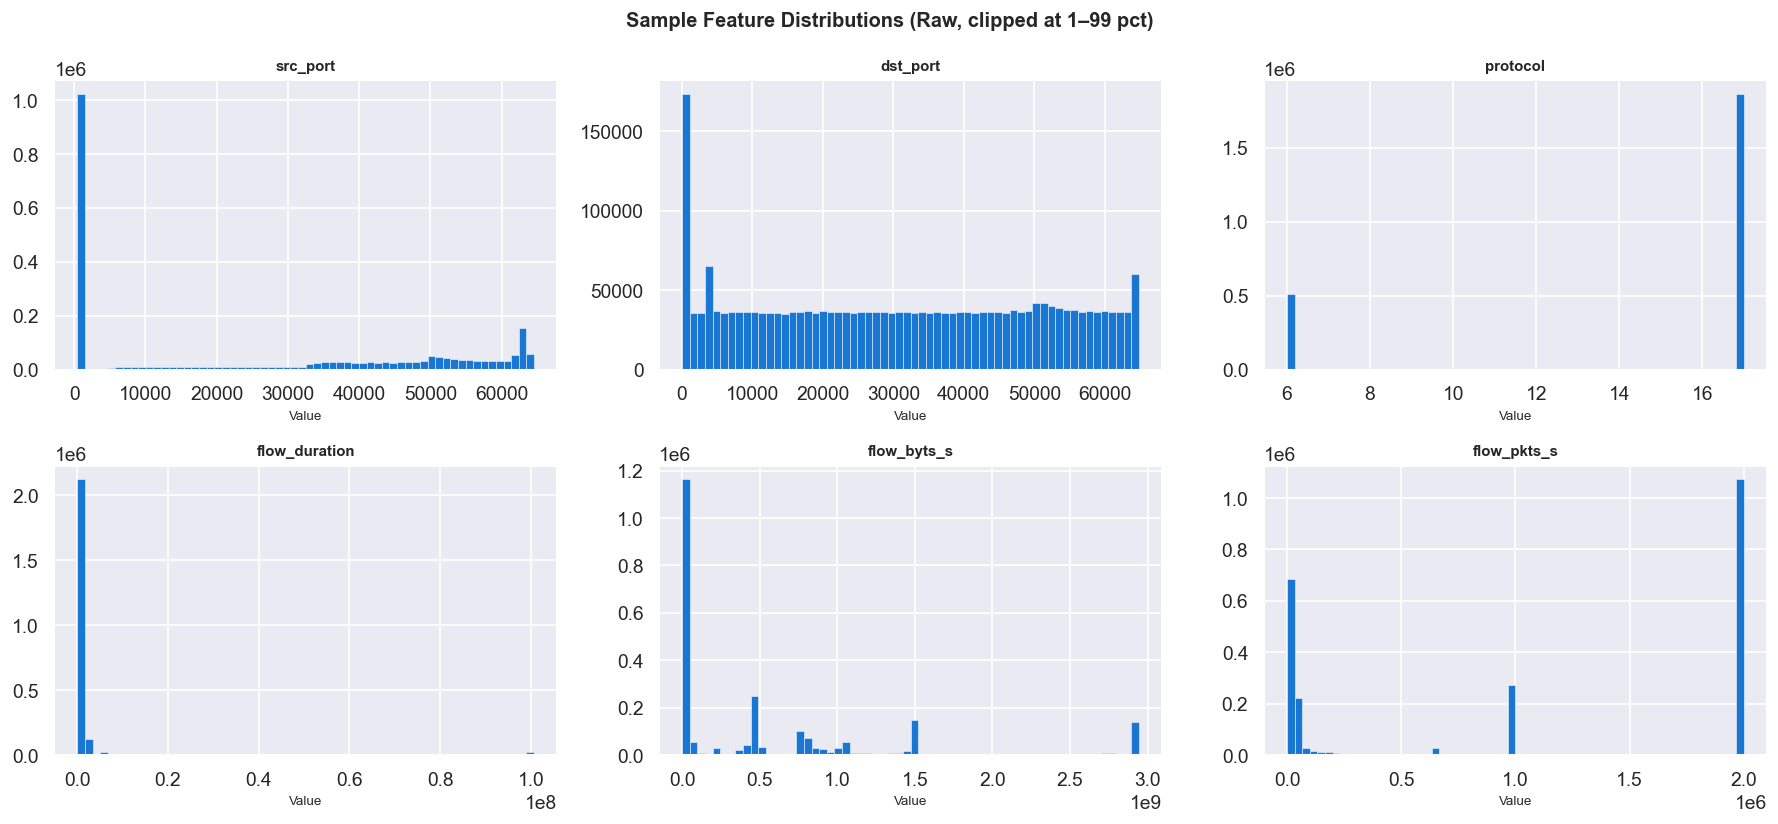

In [13]:
# Distribution of a few representative features
sample_features = X.columns[:6].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 7), dpi=120)
axes = axes.flatten()
for i, feat in enumerate(sample_features):
    axes[i].hist(X[feat].dropna().clip(lower=X[feat].quantile(0.01),
                                        upper=X[feat].quantile(0.99)),
                 bins=60, color='#1976D2', edgecolor='white', linewidth=0.3)
    axes[i].set_title(feat, fontsize=9, fontweight='bold')
    axes[i].set_xlabel('Value', fontsize=8)
fig.suptitle('Sample Feature Distributions (Raw, clipped at 1–99 pct)', fontsize=12, fontweight='bold')
plt.tight_layout()
fig.savefig(f'{OUTPUT_DIR}/fig_06_feature_dists.png', dpi=120, bbox_inches='tight')
plt.show()

## 6 · Persist Cleaned Dataset

In [14]:
out_path = f'{OUTPUT_DIR}/cleaned_dataset.parquet'
df_clean.to_parquet(out_path, index=False)

print(f'✓ Cleaned dataset saved → {os.path.abspath(out_path)}')
print(f'  Shape : {df_clean.shape}')
print(f'  Classes: {sorted(df_clean[LABEL_COL].unique().tolist())}')

✓ Cleaned dataset saved → e:\Documents\Programming\Python\project\AI\Transformer DDoS Detector\data\processed\cleaned_dataset.parquet
  Shape : (2375408, 73)
  Classes: ['Benign', 'DrDoS_LDAP', 'DrDoS_MSSQL', 'DrDoS_NTP', 'DrDoS_NetBIOS', 'DrDoS_SNMP', 'DrDoS_SSDP', 'DrDoS_UDP', 'Portmap', 'Syn', 'TFTP', 'UDP-lag', 'WebDDoS']
